# HSCT survival data clustering

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

training_features_df_file='./data/processed/02.1-scaled_encoded_training_features_df.parquet'
training_labels_df_file='./data/processed/02.1-scaled_encoded_training_labels_df.parquet'

model_file='./models/03.1-linear_regression.pkl'

## 1. Load data

Features: (28800, 178)
Labels: (28800, 2)


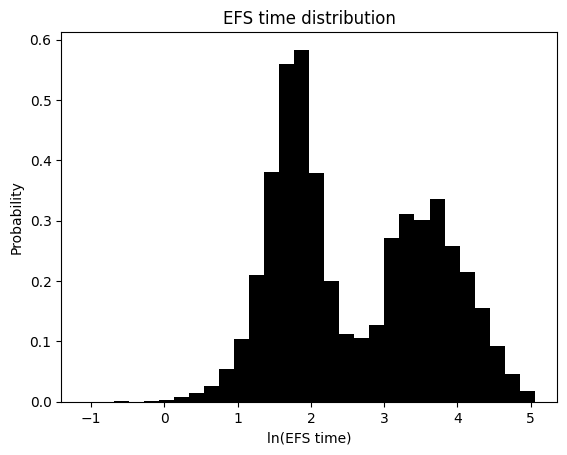

In [2]:
# Load the datasets
features_df=pd.read_parquet(training_features_df_file)
labels_df=pd.read_parquet(training_labels_df_file)

# Remove id column from training features
features_df.drop('ID', axis=1, inplace=True)

# Take the log of the labels
labels_df['efs_time']=np.log(labels_df['efs_time'])

print(f'Features: {features_df.shape}')
print(f'Labels: {labels_df.shape}')

plt.title('EFS time distribution')
plt.hist(labels_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('ln(EFS time)')
plt.ylabel('Probability')
plt.show()

## 2. Cluster analysis

### 2.1. Make predictions

In [3]:
# Load the baseline linear regression model
with open(model_file, 'rb') as input_file:
    regression_model=pickle.load(input_file)

# Make predictions for the whole training set
predictions=regression_model.predict(features_df)

predictions_df=pd.DataFrame.from_dict({
    'EFS time': labels_df['efs_time'],
    'Predicted EFS time': predictions
})

### 2.2. Cluster predictions

In [4]:
kmeans=KMeans(n_clusters=2, random_state=0, n_init="auto").fit(predictions_df)
predictions_df['Cluster']=kmeans.labels_

### 2.3. Plot

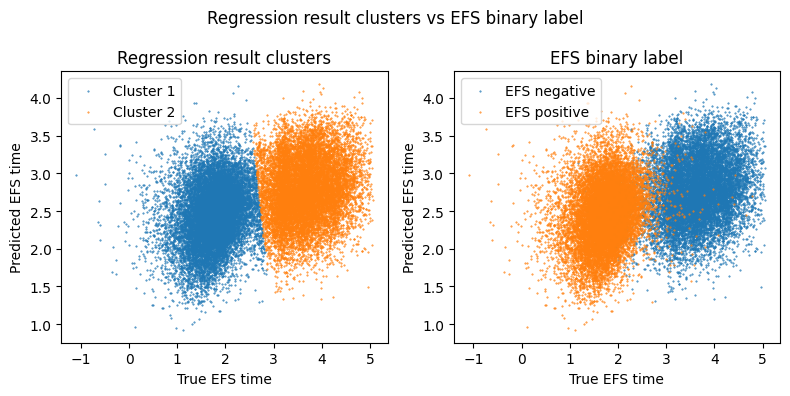

In [5]:
predictions_df['Predicted EFS time']=predictions
predictions_df['EFS time']=labels_df['efs_time']
predictions_df['EFS']=labels_df['efs']

cluster_one=predictions_df[predictions_df['Cluster'] == 0]
cluster_two=predictions_df[predictions_df['Cluster'] == 1]

efs_neg=predictions_df[predictions_df['EFS'] == 0]
efs_pos=predictions_df[predictions_df['EFS'] == 1]

# Plot the results
fig, axs=plt.subplots(1,2, figsize=(8,4))
axs=axs.flatten()

fig.suptitle('Regression result clusters vs EFS binary label')

axs[0].set_title('Regression result clusters')
axs[0].scatter(cluster_one['EFS time'], cluster_one['Predicted EFS time'], s=0.2, label='Cluster 1')
axs[0].scatter(cluster_two['EFS time'], cluster_two['Predicted EFS time'], s=0.2, label='Cluster 2')
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')
axs[0].legend(loc='best')

axs[1].set_title('EFS binary label')
axs[1].scatter(efs_neg['EFS time'], efs_neg['Predicted EFS time'], s=0.2, label='EFS negative')
axs[1].scatter(efs_pos['EFS time'], efs_pos['Predicted EFS time'], s=0.2, label='EFS positive')
axs[1].set_xlabel('True EFS time')
axs[1].set_ylabel('Predicted EFS time')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()

### 2.4. NB: clustering on features does not work

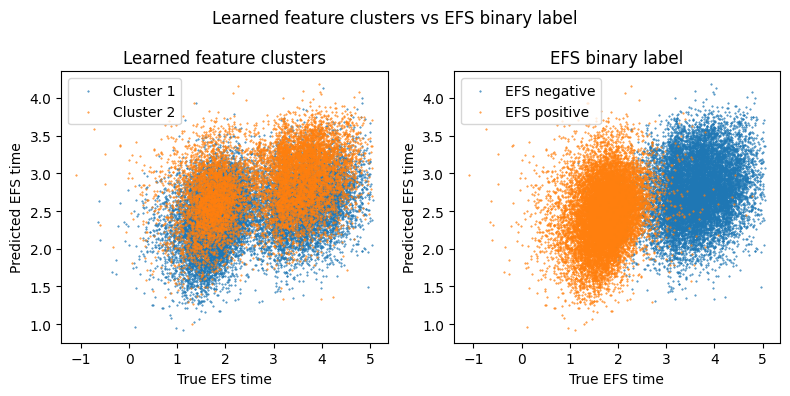

In [6]:
kmeans=KMeans(n_clusters=2, random_state=0, n_init="auto").fit(features_df)
predictions_df['Feature cluster']=kmeans.labels_

cluster_one=predictions_df[predictions_df['Feature cluster'] == 0]
cluster_two=predictions_df[predictions_df['Feature cluster'] == 1]

efs_neg=predictions_df[predictions_df['EFS'] == 0]
efs_pos=predictions_df[predictions_df['EFS'] == 1]

# Plot the results
fig, axs=plt.subplots(1,2, figsize=(8,4))
axs=axs.flatten()

fig.suptitle('Learned feature clusters vs EFS binary label')

axs[0].set_title('Learned feature clusters')
axs[0].scatter(cluster_one['EFS time'], cluster_one['Predicted EFS time'], s=0.2, label='Cluster 1')
axs[0].scatter(cluster_two['EFS time'], cluster_two['Predicted EFS time'], s=0.2, label='Cluster 2')
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')
axs[0].legend(loc='best')

axs[1].set_title('EFS binary label')
axs[1].scatter(efs_neg['EFS time'], efs_neg['Predicted EFS time'], s=0.2, label='EFS negative')
axs[1].scatter(efs_pos['EFS time'], efs_pos['Predicted EFS time'], s=0.2, label='EFS positive')
axs[1].set_xlabel('True EFS time')
axs[1].set_ylabel('Predicted EFS time')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()

## 3. Regression in clusters

### 3.1. Split data by regression clusters

In [7]:
features_df['cluster']=predictions_df['Cluster']
labels_df['cluster']=predictions_df['Cluster']

clustered_features={
    'cluster_one': features_df[features_df['cluster'] == 0],
    'cluster_two': features_df[features_df['cluster'] == 1]
}

clustered_labels={
    'cluster_one': labels_df[labels_df['cluster'] == 0],
    'cluster_two': labels_df[labels_df['cluster'] == 1]
}

### 3.2. Cluster regression

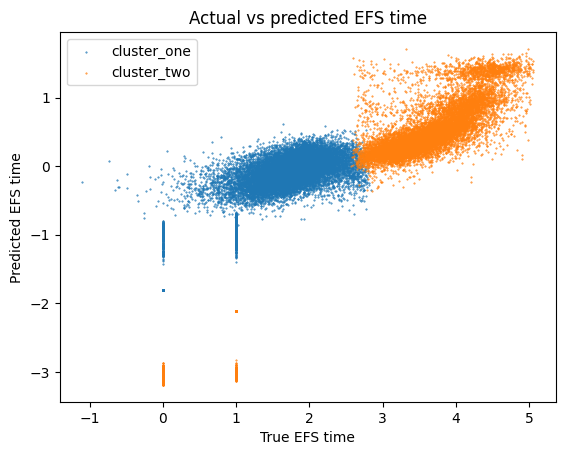

In [8]:
models={
    'cluster_one': LinearRegression(),
    'cluster_two': LinearRegression()
}

for cluster in clustered_features.keys():
    models[cluster].fit(clustered_features[cluster], clustered_labels[cluster])

predictions={}

for cluster in clustered_features.keys():
    cluster_predictions=models[cluster].predict(clustered_features[cluster])
    predictions[cluster]=cluster_predictions - np.mean(cluster_predictions) * 2


plt.title('Actual vs predicted EFS time')

for cluster in clustered_features.keys():
    plt.scatter(clustered_labels[cluster], predictions[cluster], s=0.2, label=cluster)

plt.xlabel('True EFS time')
plt.ylabel('Predicted EFS time')
plt.legend(loc='best')
plt.show()

## SSOABBM!